 # <font color=green>**FISHING OUT PHISHING WEBSITES**</font>

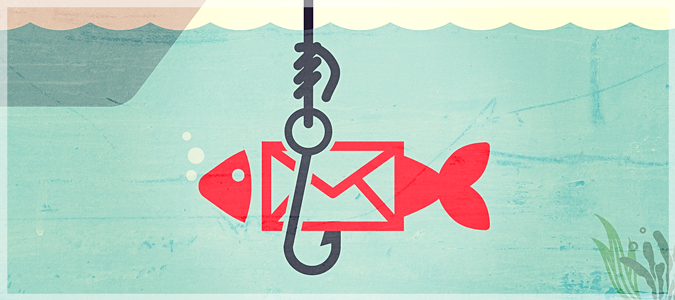


<font color=green>**Overview**</font>

This project uses machine learning to recommend a set of models for predicting phishing websites. The motivation for this project is to reduce the loss of personal and financial information by vulnerable online shoppers who often cannot distinguish a legitimate website form its phishing counterpart.

# <font color=green>BUSINESS PROBLEM</font>

Online shoppers lose money, time, and personal identifiable information to malicious websites because they are often unable to differentiate between a legitimate website and a phishing site. Cybercrimes have become rampart due to the increase in data value. The  model built within this project can be adopted across different industries; however, this project is geared to the retail/e-commerce industry and would be useful for consumers to protect themselves from cybercrimes.

This project uses data sourced from Phish Tank, Open Phish, Alexa and Yandex to build a model that classifies websites as legitimate or as phishing websites. The final machine learning model can differentiate between a legitimate website from its phishing counterpart about 90% of the time.


# <font color=green>DATA UNDRSTANDING</font>  

This project uses data sourced from Phish Tank, Open Phish, Alexa and Yandex to build a model that classifies websites as legitimate or as phishing websites. Data was downloaded from Kaggle, an online platform for data scientists. Kaggle sourced the dataset originally from Engineering Application of Artificial Intelligence, an academic journal. Dataset was constructed in May 2020 
The data used for this project is from the latest dataset publication in July 2021

The dataset contains information of 11430 URLs from both phishing and legitimate websites. The data came with 87 columns extracted from the websites page content, structure and URL syntax
The dataset is balanced, i.e., it contains 50% phishing and 50% legitimate URLs. Some of the features in the dataset include domain age, WHOIS registered domain, page rank, ratio internal /external redirection, page rank (from open PageRank) among others.

In [87]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statistics import mean
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [88]:
# Loading dataset 

Phishing_Data = pd.read_csv("dataset_phishing.csv")

# Exploring the content of the dataset

Phishing_Data.head()


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [89]:
Phishing_Data.shape

(11430, 89)

# <font color=green>DATA PREPARATION</font>

Exploratory data analysis is performed on the dataset to ensure there are no records that might contribute to the overall model than others. 

In [90]:
# Exploring data type and features

Phishing_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [91]:
# Checking for missing values in dataset

Phishing_Data.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

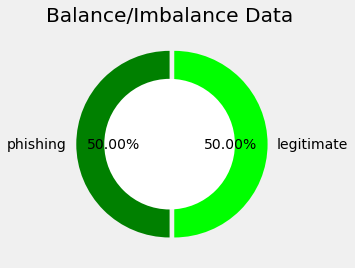

In [92]:
# Checking if data is balanced


with plt.style.context(style="fivethirtyeight"):
    plt.pie(x=dict(Phishing_Data['status'].value_counts()).values(),
           labels=dict(Phishing_Data['status'].value_counts()).keys(),
           autopct="%.2f%%",
           colors=['green','lime'],
           startangle=90,
           explode=[0,0.05])
    centre_circle=plt.Circle((0,0),0.70,fc='white')
    fig=plt.gcf()
    fig.gca().add_artist(centre_circle)
    plt.title(label="Balance/Imbalance Data")
    plt.show();

Although the dataset has no null values and contains a propotionate amount of phishing website to legitimate websites, the dataset contains 89 records. 

Lasso regularization can help filter through the features and select the best set of features to be used for modelling.

# <font color=green>FEATURE SELECTION</font>

In [93]:
# Encoding: Legitimate = 1 | Phishing = 0
# Changing the target column name form "status" to "target"

Phishing_Data['target'] = pd.get_dummies(Phishing_Data['status'])['legitimate'].astype('int')
Phishing_Data.drop('status', axis = 1, inplace=True)

Phishing_Data.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,0
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,1
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,1


In [94]:
# Dropping the URL column

Phishing_Data.drop('url', axis=1, inplace=True)
Phishing_Data.head(3)

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,target
0,37,19,0,3,0,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,1
1,77,23,1,1,0,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,0
2,126,50,1,4,1,0,1,2,0,3,...,1,0,0,14,4004,5828815,0,1,0,0


In [95]:
# Feature Engineering using Lasso Regression
# Perform Train Test Split

data_train, data_test= train_test_split(Phishing_Data, test_size=0.7, random_state=42)

In [96]:
#Scaling the dataset 

scaler=MinMaxScaler()

data_trainScaled=scaler.fit_transform(data_train)
data_testScaled=scaler.transform(data_test)

#convert the scalled data array into dataframe
data_trainScaled=pd.DataFrame(data_trainScaled, columns=data_train.columns)
data_testScaled=pd.DataFrame(data_testScaled, columns=data_test.columns)

In [97]:
# Dividing train and test data into X(predictors) and y(target)

X_train = data_trainScaled.drop('target',axis=1)
X_test = data_testScaled.drop('target',axis=1)

y_train = data_trainScaled['target']
y_test = data_testScaled['target']


In [98]:
# Finding the best alpha(lambda) for lasso regularization

lasso=Lasso()
params = {'alpha': [0.000001, 0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10]}
folds=5

lasso_model_cv=GridSearchCV(estimator=lasso, param_grid=params, scoring='r2',cv=folds, return_train_score=True, verbose=1)
lasso_model_cv.fit(X_train, y_train)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10]},
             return_train_score=True, scoring='r2', verbose=1)

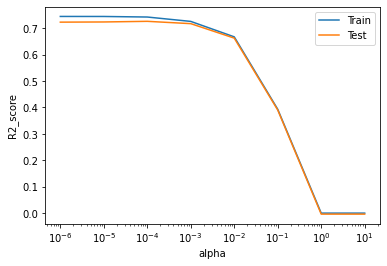

In [99]:
# Visualizing best alpha

GridSearchCV(cv=5, estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
             max_iter=1000, normalize=False, positive=False, precompute=False, random_state=None,
             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None, param_grid={'alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

cv_results= pd.DataFrame(lasso_model_cv.cv_results_)

plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'], label='Train')
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'], label='Test')
plt.xlabel('alpha')
plt.ylabel('R2_score')
plt.xscale('log')
plt.legend()
plt.show()

The alpha with the hightest R2 score is 0.001 

In [100]:
# Using lasso regularization for feature selection

lasso = Lasso(alpha=0.001)
lasso.fit(X_train, y_train)
print(lasso.coef_)

[-0.         -0.         -0.06318404 -0.          0.28104019 -0.
 -0.23469744 -0.          0.         -0.          0.          0.
 -0.         -0.          0.         -0.          0.         -0.
  0.          0.          0.33484522 -0.         -0.07522808 -0.
  0.04172668 -0.12946019 -0.07889163  0.          0.          0.
  0.          0.         -0.0416778  -0.          0.00647082 -0.09133493
  0.          0.05320197  0.         -0.         -0.          0.
  0.         -0.07545562 -0.         -0.         -0.         -0.
 -0.         -0.         -0.35782873 -0.         -0.         -0.
 -0.          0.          0.          0.         -0.14171216  0.
  0.          0.          0.1121656   0.          0.          0.
  0.02675022  0.01754548  0.          0.06248502  0.11522807  0.
 -0.          0.          0.05672679  0.         -0.         -0.
 -0.07786506  0.03335544  0.05107013 -0.093376    0.10369126  0.
 -0.         -0.45485935  0.4813116 ]


In [101]:
# Matching variables to coefficients 

lasso_dict = dict(zip(X_train.columns,lasso.coef_))

# Finding the mean of coefficients 

mean(lasso_dict[k] for k in lasso_dict)


-0.0015857072552889994

The mean of coefficients is approximatly zero. All features with cofficients more tha zero is selected.

In [102]:
# Filter dictionary for only non-zero coefficients and round coeficient to 4 significant digits

predictors={}
for i in lasso_dict:
    if lasso_dict[i]>0:
        predictors[i]= round(lasso_dict[i],4)

# Sorting predictors 

sortedpredictors = sorted(predictors.items(), key=lambda x:x[1], reverse=True)
OrderedPredictors = dict(sortedpredictors)

print(OrderedPredictors)

{'page_rank': 0.4813, 'nb_www': 0.3348, 'nb_hyphens': 0.281, 'ratio_extMedia': 0.1152, 'ratio_extRedirection': 0.1122, 'domain_age': 0.1037, 'ratio_intMedia': 0.0625, 'safe_anchor': 0.0567, 'nb_redirection': 0.0532, 'whois_registered_domain': 0.0511, 'https_token': 0.0417, 'domain_with_copyright': 0.0334, 'external_favicon': 0.0268, 'links_in_tags': 0.0175, 'random_domain': 0.0065}


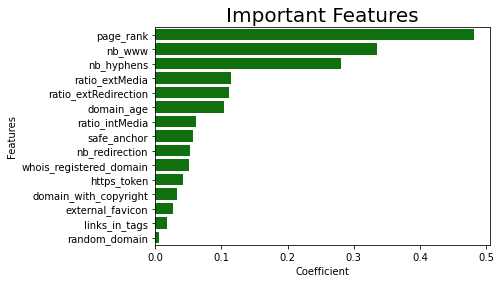

In [103]:
# Visualizing predictors that are important to target variable

Feature = list(OrderedPredictors.keys())
Coefficient = list(OrderedPredictors.values())

sns.barplot(x=Coefficient, y=Feature, color="green")

plt.xlabel('Coefficient', fontsize=10);
plt.ylabel('Features', fontsize=10);
plt.title("Important Features", fontsize=20);

Before running modelling algorithms, the data is first prepared using insights deduced from feature engineering.

In [104]:
# Creating a new dataframe based on feature selection

Data = Phishing_Data[["page_rank","nb_www","nb_hyphens","ratio_extMedia",
                     "ratio_extRedirection","domain_age","ratio_intMedia",
                     "safe_anchor","nb_redirection","whois_registered_domain","https_token",
                     "domain_with_copyright","external_favicon","links_in_tags","random_domain","target"]].copy()

Data.head()

,page_rank,nb_www,nb_hyphens,ratio_extMedia,ratio_extRedirection,domain_age,ratio_intMedia,safe_anchor,nb_redirection,whois_registered_domain,https_token,domain_with_copyright,external_favicon,links_in_tags,random_domain,target
0,4,1,0,0.000000,0.875000,-1,100.000000,0.0,0,0,1,1,0,80.000000,0,1
1,2,0,0,20.000000,0.000000,5767,80.000000,100.0,1,0,1,0,0,100.000000,0,0
2,0,0,1,0.000000,0.000000,4004,0.000000,100.0,1,0,0,0,0,100.000000,0,0
3,3,0,0,3.571429,0.250000,-1,96.428571,62.5,1,0,1,0,0,100.000000,0,1
4,6,1,2,100.000000,0.537037,8175,0.000000,0.0,1,0,1,1,0,76.470588,0,1


In [105]:
# Ensuring new data is complete

Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   page_rank                11430 non-null  int64  
 1   nb_www                   11430 non-null  int64  
 2   nb_hyphens               11430 non-null  int64  
 3   ratio_extMedia           11430 non-null  float64
 4   ratio_extRedirection     11430 non-null  float64
 5   domain_age               11430 non-null  int64  
 6   ratio_intMedia           11430 non-null  float64
 7   safe_anchor              11430 non-null  float64
 8   nb_redirection           11430 non-null  int64  
 9   whois_registered_domain  11430 non-null  int64  
 10  https_token              11430 non-null  int64  
 11  domain_with_copyright    11430 non-null  int64  
 12  external_favicon         11430 non-null  int64  
 13  links_in_tags            11430 non-null  float64
 14  random_domain         

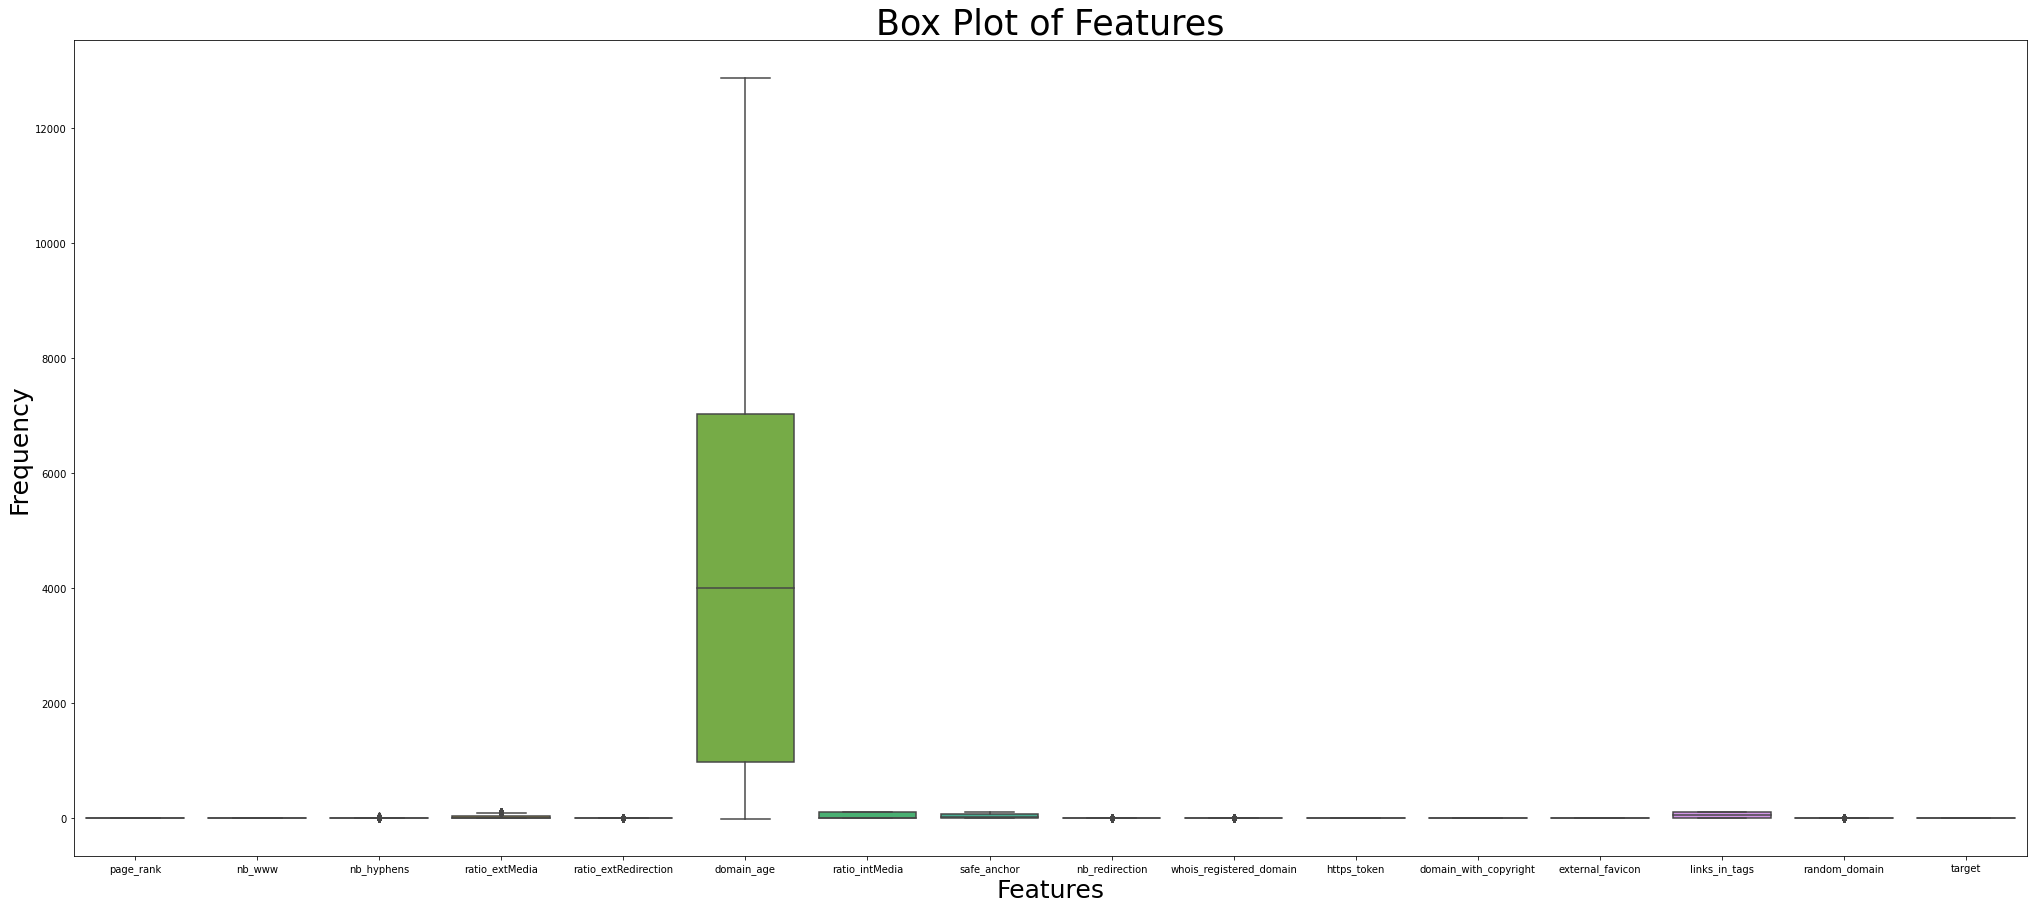

In [106]:
# Visualizing data for variability

fig = plt.gcf()
fig.set_size_inches(35, 15)

plt.xlabel('Features', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
sns.boxplot(data=Data)
plt.title("Box Plot of Features", fontsize=35);

The domain age feature has a high variance compared to its counterpart. As mitigation, the domain_age column is removed. The random_domain feature is also removed because it contributes little to nothing to the target 

In [107]:
# Creating data that will be used for modelling


ModelData = Data[["page_rank","nb_www","nb_hyphens","ratio_extMedia",
                     "ratio_extRedirection","ratio_intMedia",
                     "safe_anchor","nb_redirection","whois_registered_domain","https_token",
                     "domain_with_copyright","external_favicon","links_in_tags","target"]].copy()

ModelData.head()

,page_rank,nb_www,nb_hyphens,ratio_extMedia,ratio_extRedirection,ratio_intMedia,safe_anchor,nb_redirection,whois_registered_domain,https_token,domain_with_copyright,external_favicon,links_in_tags,target
0,4,1,0,0.000000,0.875000,100.000000,0.0,0,0,1,1,0,80.000000,1
1,2,0,0,20.000000,0.000000,80.000000,100.0,1,0,1,0,0,100.000000,0
2,0,0,1,0.000000,0.000000,0.000000,100.0,1,0,0,0,0,100.000000,0
3,3,0,0,3.571429,0.250000,96.428571,62.5,1,0,1,0,0,100.000000,1
4,6,1,2,100.000000,0.537037,0.000000,0.0,1,0,1,1,0,76.470588,1


# <font color=green>MODELLING</font>

In [108]:
# Perform Train Test Split on Model Data before scalling to avoid leakage

data_train, data_test= train_test_split(ModelData, test_size=0.7, random_state=42)

In [109]:
#Scaling the model data

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

trainScaled = scaler.fit_transform(data_train)
testScaled = scaler.transform(data_test)

#convert the scaled data array into dataframe
trainScaled = pd.DataFrame(data_trainScaled, columns=data_train.columns)
testScaled = pd.DataFrame(data_testScaled, columns=data_test.columns)

In [110]:
# Dividing train and test data into X(predictors) and y(target)

X_trainM = trainScaled.drop('target',axis=1)
X_testM = testScaled.drop('target',axis=1)

y_trainM = trainScaled['target']
y_testM = testScaled['target']

Baseline model: Logistic Regression
    Binary prediction using mathematics to find relationship between two data factors

In [111]:
# Runing Logistic Regression

Baseline = LogisticRegression()
Baseline.fit(X_trainM, y_trainM)

# Test set predictions
y_predicted = Baseline.predict(X_testM)

In [112]:
#Performance on train and test data

Accuracy = Baseline.score(X_trainM, y_trainM)
print("Train Accuracy: {:.2f}%".format(Accuracy * 100))

Accuracy = Baseline.score(X_testM, y_testM)
print("Test Accuracy: {:.2f}%".format(Accuracy * 100))

Train Accuracy: 83.67%
Test Accuracy: 83.30%


In [113]:
# Classification report

print(classification_report(y_testM, y_predicted))

              precision    recall  f1-score   support

         0.0       0.85      0.81      0.83      4027
         1.0       0.82      0.85      0.84      3974

    accuracy                           0.83      8001
   macro avg       0.83      0.83      0.83      8001
weighted avg       0.83      0.83      0.83      8001



Second model: Decision Tree
    Makes predictions based on a previous set of established (and all-inclusive) patterns of outcomes 

In [114]:
# Instantiate and fit a DecisionTreeClassifier

SecondModel = DecisionTreeClassifier(criterion='gini', max_depth=5) 
SecondModel.fit(X_trainM, y_trainM)

# Test set predictions
Pred = SecondModel.predict(X_testM)

In [115]:
#Performance on train and test data

Accuracy = SecondModel.score(X_trainM, y_trainM)
print("Train Accuracy: {:.2f}%".format(Accuracy * 100))

Accuracy = SecondModel.score(X_testM, y_testM)
print("Test Accuracy: {:.2f}%".format(Accuracy * 100))

Train Accuracy: 88.33%
Test Accuracy: 86.08%


In [116]:
# Classification report

print(classification_report(y_testM, Pred))

              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      4027
         1.0       0.85      0.87      0.86      3974

    accuracy                           0.86      8001
   macro avg       0.86      0.86      0.86      8001
weighted avg       0.86      0.86      0.86      8001



Third model: Random Forest
    Also makes its prediction based on learned patterns by combining multiple decision trees to reach a single conclusion

In [117]:
# Instantiate and fit a RandomForestClassifier

ThirdModel = RandomForestClassifier(n_estimators=100, max_depth= 5)
ThirdModel.fit(X_trainM, y_trainM)

# Test set predictions
Predict = ThirdModel.predict(X_testM)

In [118]:
# Accuracy score for train data
print("Train Accuracy: {:.2f}%" .format(ThirdModel.score(X_trainM, y_trainM)))

# Accuracy score for test data
print("Test Accuracy: {:.2f}%" .format(ThirdModel.score(X_testM, y_testM)))

Train Accuracy: 0.90%
Test Accuracy: 0.88%


In [119]:
# Classification report

print(classification_report(y_testM, Predict))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      4027
         1.0       0.88      0.88      0.88      3974

    accuracy                           0.88      8001
   macro avg       0.88      0.88      0.88      8001
weighted avg       0.88      0.88      0.88      8001



Best Performing Model: XGBoost
    Uses sequentially built shallow decision trees to provide flexible training methods that avoids overfitting

In [120]:
# Instantiate and fit a XGBoostClassifier 

BestModel = XGBClassifier(learning_rate=0.1)
BestModel.fit(X_trainM, y_trainM)

# Test set predictions
y_pred = BestModel.predict(X_testM)

In [121]:
# Accuracy score for train data
print("Train Accuracy: {:.2f}%" .format(BestModel.score(X_trainM, y_trainM)))

# Accuracy score for test data
print("Test Accuracy: {:.2f}%" .format(BestModel.score(X_testM, y_testM)))

Train Accuracy: 0.97%
Test Accuracy: 0.91%


In [122]:
# Classification report

print(classification_report(y_testM, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      4027
         1.0       0.91      0.90      0.91      3974

    accuracy                           0.91      8001
   macro avg       0.91      0.91      0.91      8001
weighted avg       0.91      0.91      0.91      8001



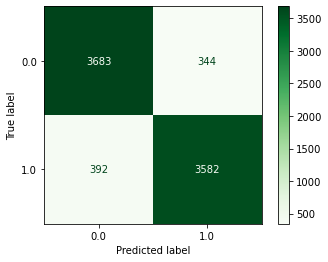

In [123]:
# Visualizing using a confusion matrix

cm = confusion_matrix(y_testM, y_pred)
plot_confusion_matrix(BestModel, X_testM, y_testM, cmap=plt.cm.Greens)

plt.show();

# <font color=green>CONCLUSION</font>

The best performing model is the XGBoost. The evaluation metrics from the training data shows all the models might be overfitting, although the overfitting is not significant for some models, it will be interesting to see how the model adjusts with an increase in the availability of datasets. 

**The follwing information can be deduced:**
- Based on the modelling methodolgies utilizd, XGBoost peformed the best in predicting if a website is phishing or legitimate.
- The baseline model (logistic regression) classifies websites correctly 83% of the time, while XGBoost has a 91% overall classifying rate.
- Among all the websites predicted as legitimate, 91% of them are true positives, i.e they were classified as legitimate website and are indeed legitimate.

**This project can be expanded upon in the following ways:**
- Increasing the amount of dataset for  more robust model
- Classsification of phishng emails
- Classsification of phishng emails
- Classification of shortened URLs, e.g URLs that have been shortened using Bitly, TinyURL
- Embeding the URL detection model to a web browser
- Creating a  model that containd actionable detection that reports or close domains of phishing URLs
